## Cluster Studies (Jan)

Here is an updated version of the ClusterStudies.ipynb notebook, using uproot4 and newer versions of our plotting utilities.

In [1]:
#import libraries and some constants
import os, sys, json, pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ROOT as rt # I will use this for some plotting
import uproot as ur

path_prefix = os.getcwd() + '/../'
modelpath = path_prefix+'clusters/Models/'

if(path_prefix not in sys.path): sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
from util import qol_util as qu

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]
cell_shapes = {layers[i]:(len_eta[i],len_phi[i]) for i in range(len(layers))}

Welcome to JupyROOT 6.24/00


In [2]:
# fancy display names for each pion type
pi_latex = {
    'p0': '#pi^{0}',
    'pp': '#pi^{#pm}',
}

# Plotting settings
# xkcd -- turn this on for fun-looking (but marginally less useful) plots
use_xkcd = False
if(use_xkcd):
    mode = 'light'
    plt.xkcd(scale=.75,length=100,randomness=1)
    
# plotting style -- manages our color palette and object colors
mode = 'dark' # for publications, use "light"
plotstyle = qu.PlotStyle(mode)
plotstyle.SetStyle()
    
# some matplotlib-specific stuff
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

Let's fetch the data we want to look at. We'll need to change the code below depending on what dataset we're inspecting (and however you've stored it on your system).

In [15]:
inputpath = path_prefix+'data/pion/'
drpath = os.getcwd() + '/dr/pion/'

datafiles = {
    'p0':inputpath + 'user.angerami.mc16_13TeV.900246.PG_singlepi0_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/*.root',
    'pp':inputpath + 'user.angerami.mc16_13TeV.900247.PG_singlepion_logE0p2to2000.e8312_e7400_s3170_r12383.v01-45-gaa27bcb_OutputStream/*.root'
}

drfiles = {key: val.replace(inputpath, drpath) for key,val in datafiles.items()}

cluster_branches = [
    'cluster_E', 'cluster_E_LCCalib', 
    'cluster_Pt', 'cluster_Eta', 'cluster_Phi', 
    'cluster_nCells',
    'cluster_ENG_CALIB_TOT', 'cluster_EM_PROBABILITY',
]

dr_branches = [
    'cluster_E', 'cluster_Eta', 'cluster_Phi', 'cluster_ENG_CALIB_TOT',
    'truth_E', 'truth_Eta', 'truth_Phi', 'truth_PdgId',
    'dR'
]

event_branches = [
    'truthPartPt',
    'truthPartE',
    'truthPartEta',
    'truthPartPhi',
    'nCluster',
    'clusterCount'
]

colors = {
    'pp':rt.kRed,
    'p0':plotstyle.curve
}

keys = list(datafiles.keys())

In [4]:
cluster_tree = {
    key:ur.lazy(':'.join((val,'ClusterTree')), branch_filter=lambda x: x.name in cluster_branches)
    for key,val in datafiles.items()
}

dr_tree = {
    key:ur.lazy(':'.join((val,'dr_info')), branch_filter=lambda x: x.name in dr_branches)
    for key,val in drfiles.items()
}

In [5]:
# Perform some cuts on the data
indices = {
    key:np.full(len(val),True,dtype=bool)
    for key,val in cluster_tree.items()
}

cuts = {
    'eta':('cluster_Eta','window',(-0.7,0.7)),
    'energy':('cluster_ENG_CALIB_TOT','lower',0.2)
}

for cutname, cut in cuts.items():
    var, cuttype, cutval = cut
    
    for key in keys:
        if cuttype == 'lower': sel = cluster_tree[key][var] > cutval
        elif cuttype == 'upper': sel = cluster_tree[key][var] < cutval
        elif cuttype == 'window':sel = (cluster_tree[key][var] > cutval[0]) * (cluster_tree[key][var] < cutval[1])
        else: continue
        indices[key] *= sel.to_numpy()
        
cluster_tree = {key:val[indices[key]] for key,val in cluster_tree.items()}
dr_tree      = {key:val[indices[key]] for key,val in dr_tree.items()}

In [6]:
# Sanity check that things line up
assert(np.sum(cluster_tree['pp']['cluster_E'] - dr_tree['pp']['cluster_E']) == 0.)

In [7]:
# Convenience functions for histogramming, from numpy to ROOT.
# Much faster than looping over data for sequential filling of histograms.
def hist1d(x,h):
    N = h.GetNbinsX()
    bin_i = h.GetBinLowEdge(1)
    bin_f = h.GetBinLowEdge(N) + h.GetBinWidth(N)    
    np_hist = np.histogram(x, bins=N, range=(bin_i, bin_f))[0]
    for i in range(N):
        h.SetBinContent(i+1, np_hist[i])
    return

def hist2d(x,y,h):
    
    Nx = h.GetNbinsX()
    Ny = h.GetNbinsY()
    
    bin_xi = h.GetXaxis().GetBinLowEdge(1)
    bin_xf = h.GetXaxis().GetBinLowEdge(Nx) + h.GetXaxis().GetBinWidth(Nx)
    
    bin_yi = h.GetYaxis().GetBinLowEdge(1)
    bin_yf = h.GetYaxis().GetBinLowEdge(Ny) + h.GetYaxis().GetBinWidth(Ny)
      
    np_hist = np.histogram2d(x,y, bins=(Nx,Ny), range=((bin_xi,bin_xf),(bin_yi, bin_yf)))[0]
    for i in range(Nx):
        for j in range(Ny):
            h.SetBinContent(i+1,j+1,np_hist[i,j])
    return

## Plotting $\Delta R$ (versus Energy)

In [11]:
# 1D histograms
h1 = {
    'dR':{
        key:rt.TH1F(qu.RN(),'{};#Delta R;% Count'.format(pi_latex[key]),120,0.,6.) 
        for key in keys
    },
    'cluster_E':{
        key:rt.TH1F(qu.RN(),'{};E;% Count'.format(pi_latex[key]),2500,0.,2500.) 
        for key in keys
    }
}


h2 = {
    key:rt.TH2F(qu.RN(),'{};#Delta R;Energy [GeV];% Count'.format(pi_latex[key]),240,0.,6., 2500,0.,2500.) 
    for key in keys
}

for key in keys:
    n = len(cluster_tree[key])
    hist1d(dr_tree[key]['dR'].to_numpy(), h1['dR'][key])
    hist1d(cluster_tree[key]['cluster_E'].to_numpy(), h1['cluster_E'][key])
    
    hist2d(
        dr_tree[key]['dR'].to_numpy(), 
        cluster_tree[key]['cluster_E'].to_numpy(), 
        h2[key]
    )
    
    for h in h1.values():
        h[key].Scale(1./h[key].Integral())

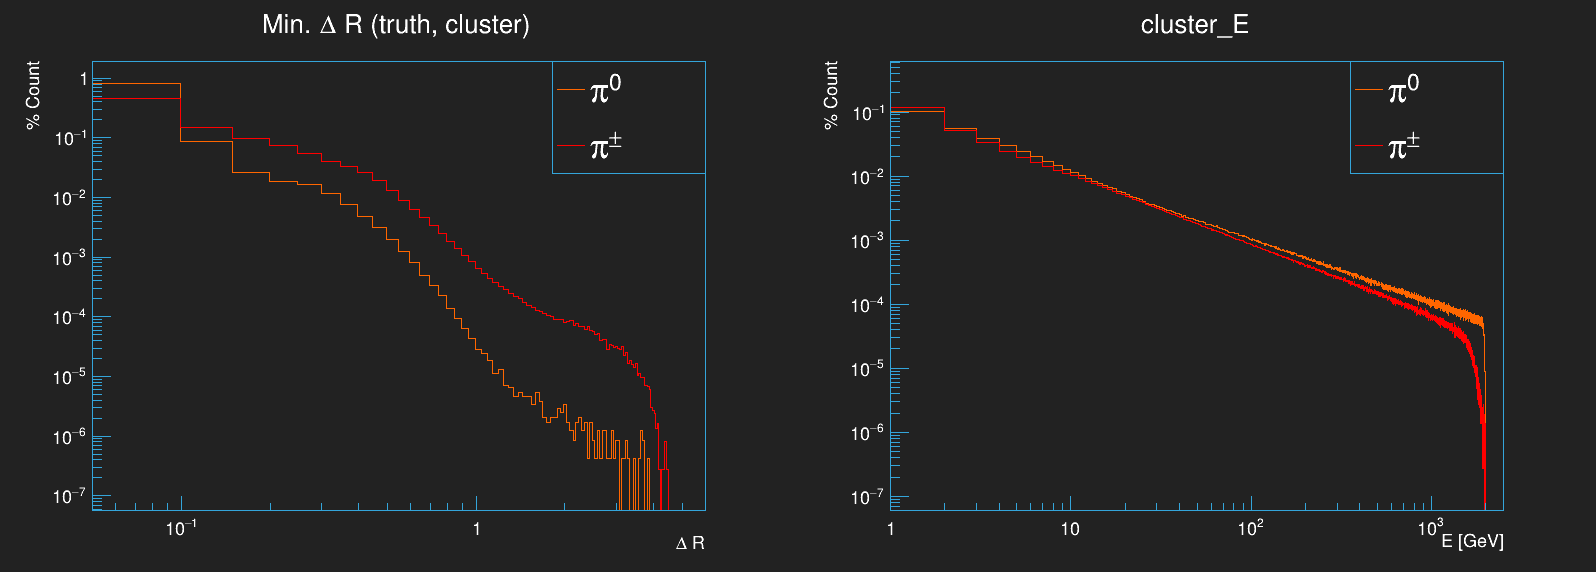

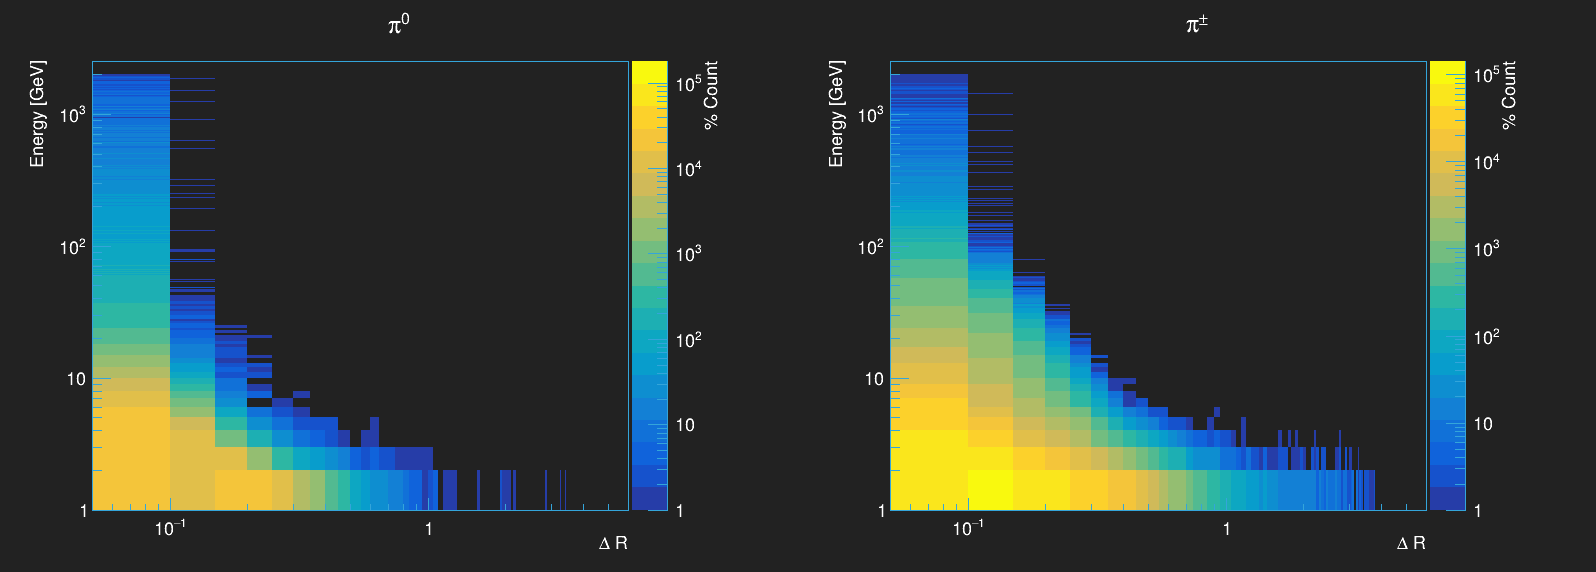

In [74]:
rt.gStyle.SetOptStat(0)
c1 = rt.TCanvas(qu.RN(),'c1',1600,600)
c2 = rt.TCanvas(qu.RN(),'c2',1600,600)
c1.Divide(2,1)
c2.Divide(2,1)
margin = 0.2

c1.cd(1)
hstack_a = rt.THStack()
legend = rt.TLegend(0.7,0.7,0.9,0.9)
legend.SetTextColor(plotstyle.text)
for key in keys: 
    h1['dR'][key].SetLineColor(colors[key])
    hstack_a.Add(h1['dR'][key])
    legend.AddEntry(h1['dR'][key],pi_latex[key],'l')
hstack_a.SetTitle('Min. #Delta R (truth, cluster);#Delta R;% Count')
hstack_a.Draw('NOSTACK HIST')
legend.Draw()
rt.gPad.SetLogx()
rt.gPad.SetLogy()

c1.cd(2)
hstack_b = rt.THStack()
for key in keys: 
    h1['cluster_E'][key].SetLineColor(colors[key])
    hstack_b.Add(h1['cluster_E'][key])
hstack_b.SetTitle('cluster_E;E [GeV];% Count')
hstack_b.Draw('NOSTACK HIST')
legend.Draw()
rt.gPad.SetLogx()
rt.gPad.SetLogy()

c2.cd()
for i,key in enumerate(keys):
    c2.cd(i+1)
    rt.gPad.SetRightMargin(margin)
    h2[key].Draw('COLZ')
    #colorbar = h2[key].GetListOfFunctions().FindObject('palette')
    #colorbar.SetX1NDC(1.- 0.9 * margin)
    #colorbar.SetX2NDC(1.- 0.7 * margin)
    rt.gPad.SetLogx()
    rt.gPad.SetLogy()
    rt.gPad.SetLogz()
    
c1.Draw()
c2.Draw()

Let's also look at the PDG Id's of the nearest truth particles.

In [57]:
pdg_codes = {
    11 : 'e^{#pm}',
    22 : '#gamma',
    111 : '#pi^{0}',
    211: '#pi^{#pm}'
}

pdg_vals = {
    11: 0,
    22: 1,
    111: 2,
    211: 3
}

pdg_bar_chart = {
    key: rt.TH1F(qu.RN(),'Truth match;Particle;% Count',4,0,4)
    for key in keys
}

for key,chart in pdg_bar_chart.items():
    vals = np.abs(dr_tree[key]['truth_PdgId'].to_numpy())
    vals = np.array([pdg_vals[x] for x in vals])
    hist1d(vals,chart)
    chart.Scale(1./chart.Integral())
    

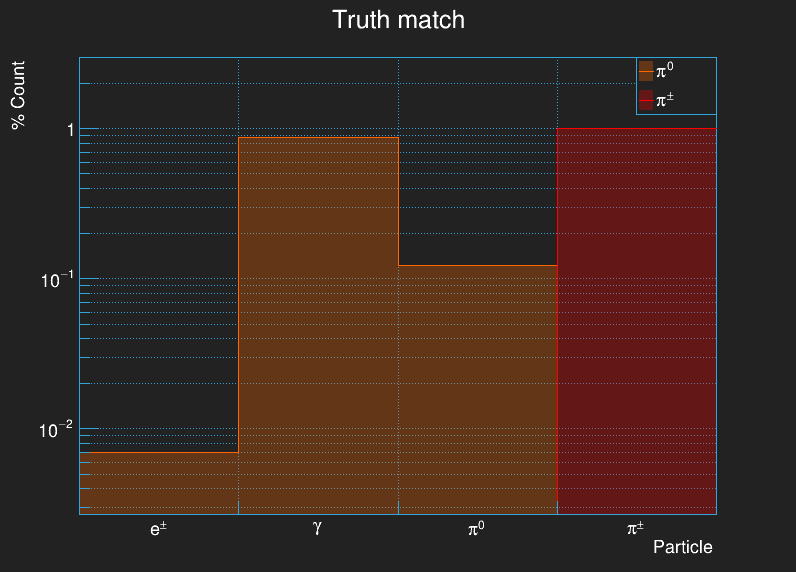

In [73]:
c = rt.TCanvas(qu.RN(),'c',800,600)
legend = rt.TLegend(0.8,0.8,0.9,0.9)
legend.SetTextColor(plotstyle.text)
stack = rt.THStack()
stack.SetTitle('Truth match;Particle;% Count')
for key,chart in pdg_bar_chart.items(): 
    chart.SetLineColor(colors[key])
    chart.SetFillColorAlpha(colors[key],0.3)
    stack.Add(chart)
    legend.AddEntry(chart,pi_latex[key],'lf')

stack.Draw('NOSTACK HIST')
legend.Draw()
rt.gPad.SetLogy()
stack.SetMaximum(3. * stack.GetMaximum())
rt.gPad.SetGrid()

stack.GetXaxis().SetNdivisions(-4)
stack.GetXaxis().SetLabelSize(0.05)
for i,code in enumerate(pdg_codes.values()):
    stack.GetXaxis().SetBinLabel(i+1,code)

c.Draw()

We see that for charged pions, the truth particles are always the truth particles themselves -- this makes sense (the truth particles probably come from the generator level, *before* the hadronic showering).

For the neutral pions, we have a mix of gammas, electrons/positrons and neutral pions themselves. The gammas completely dominate.